In [1]:
import os
import math
import aux
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy
import cv2

I've built a function to search for the fires based on the B12 band. Let's see how it worked!

In [2]:
fire_threshold=90
fire_pixels_pct=0.03
coverage_percentage=100
cloudy_percentage=50

min_b12 = aux.search_fire_b12(coverage_percentage,cloudy_percentage,fire_threshold,fire_pixels_pct)

98 images to download.
Found 12 tiles possibly containing a fire.


In [3]:
df = pandas.read_csv('fire_records.csv')

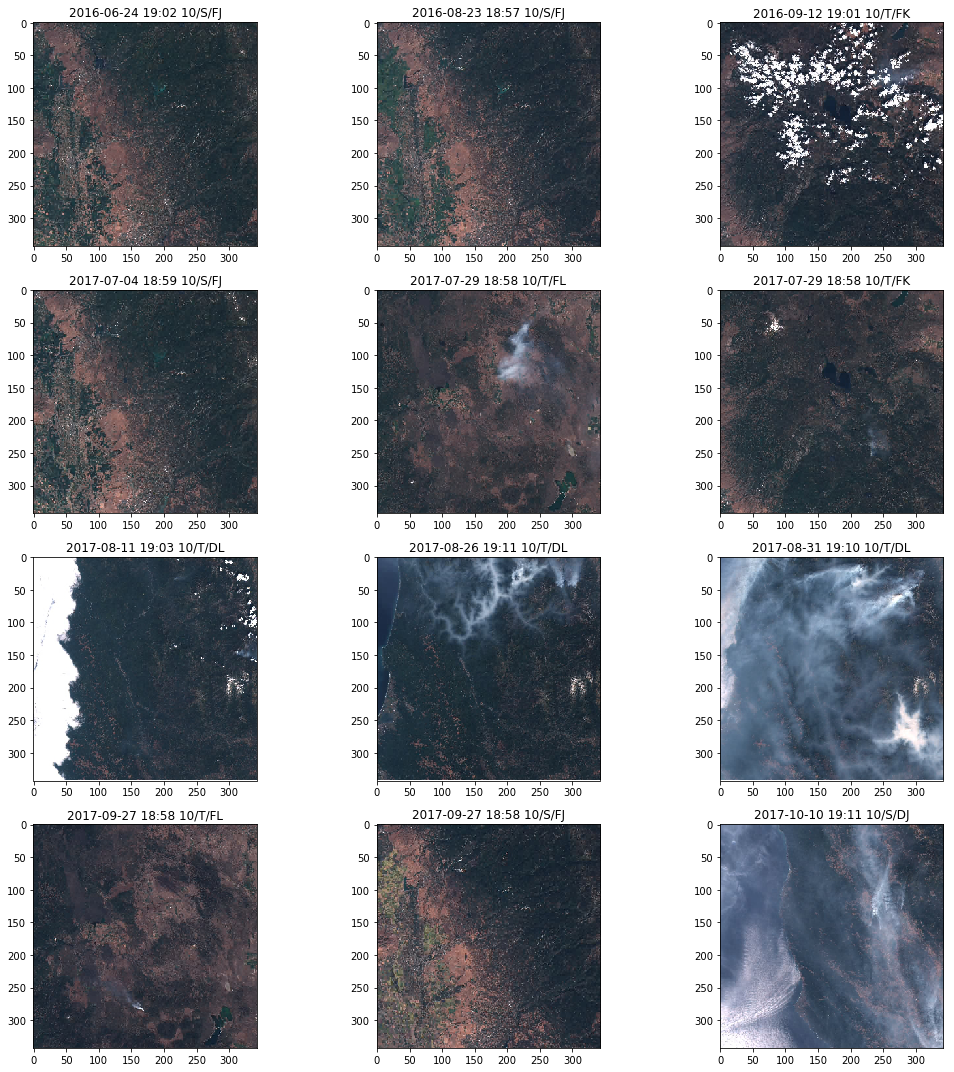

In [4]:
cols = 3
rows = math.ceil(len(df)/(cols))

f, axarr = plt.subplots(rows, cols, figsize=(15,15))

img = [mpimg.imread(os.path.join(aux.DATA_FOLDER,path)) for path in df.path]

times = df.timestamp.str[0:16]+' '+df.path.str[6:13]

c=0
for i in range(rows):
    for w in range(cols):
        if c == len(img):
            break
        axarr[i,w].imshow(img[c],cmap='gray')
        axarr[i,w].set_title(times[c])
        c+=1
plt.tight_layout()

plt.show()

So we have what seems to be 8 actual fires in 12 pictures. Pretty good, but we should be able to improve this. Why are those images from section 10/S/FJ being selected?

I'll try to understand what is going on in these misclassified tiles. Let's download every band for these tiles first.

In [5]:
bands = ['B01.jp2', 'B02.jp2','B03.jp2','B04.jp2','B05.jp2','B06.jp2','B07.jp2',
         'B08.jp2','B09.jp2','B10.jp2','B11.jp2','B12.jp2','B8A.jp2']

for i in range(11):
    path=df.path.str[:-4][i]
    for band in bands:
            aux.download_file(os.path.join(path,band))

Let's see each band on the first tile, for example.

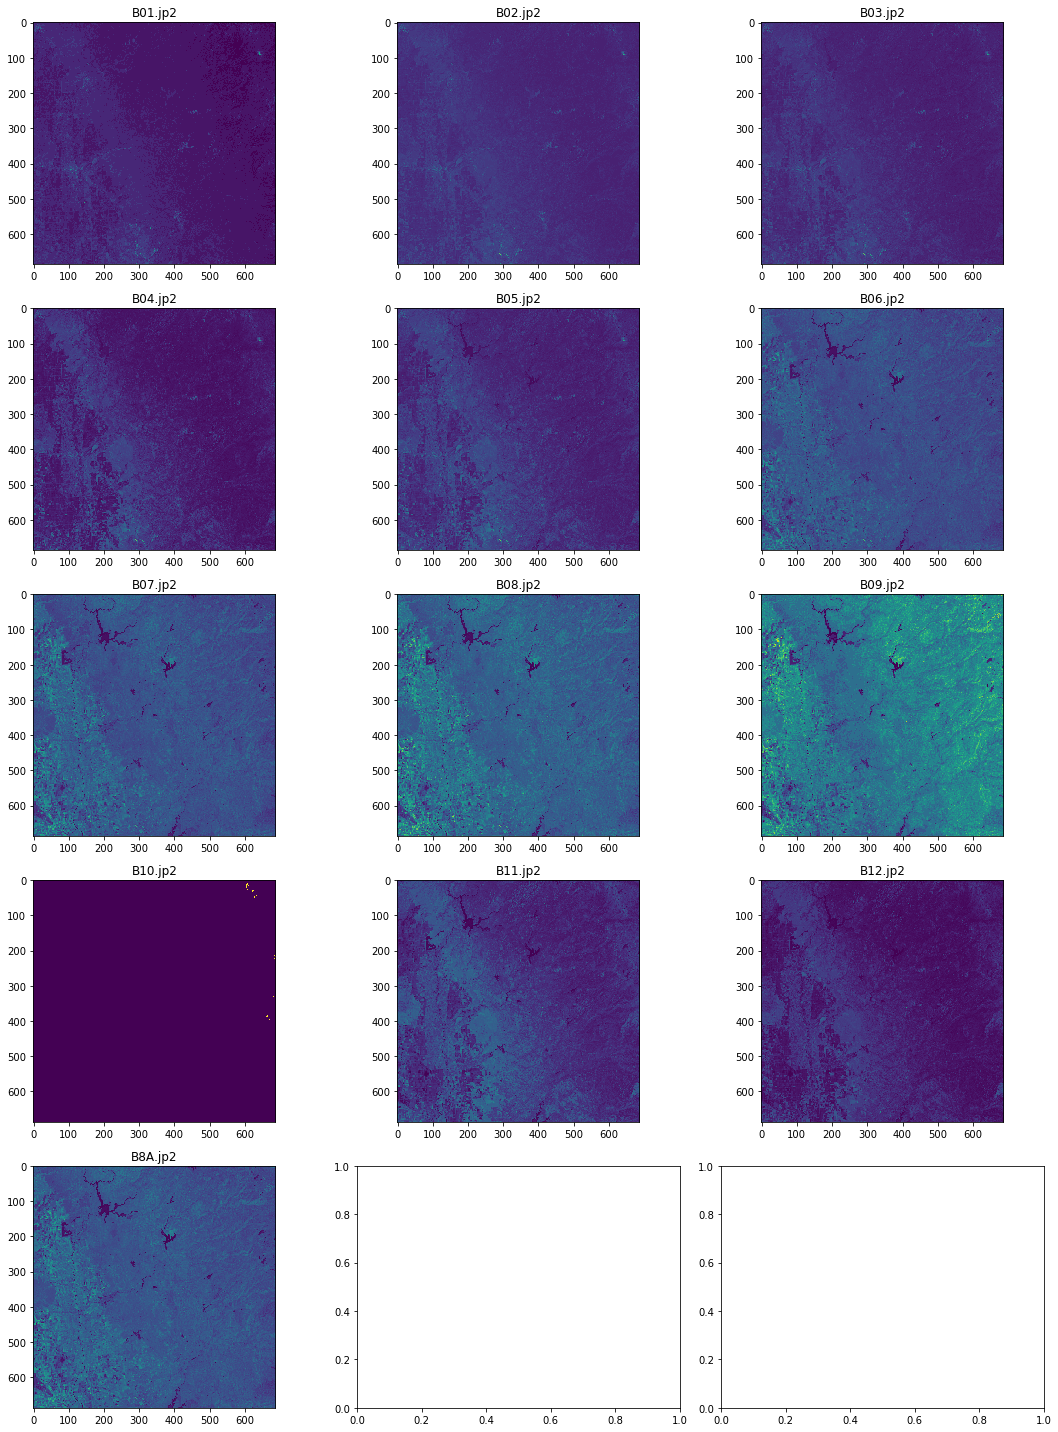

In [6]:
tile = 0
path=df.path.str[:-4][tile]

cols = 3
rows = math.ceil(len(bands)/(cols))

f, axarr = plt.subplots(rows, cols, figsize=(15,20))

img_bands = [cv2.imread(os.path.join(aux.DATA_FOLDER,path,band),cv2.IMREAD_GRAYSCALE) for band in bands]

c=0
for i in range(rows):
    for w in range(cols):
        if c == len(img_bands):
            break
        axarr[i, w].imshow(img_bands[c])
        axarr[i, w].set_title(bands[c])
        c+=1
plt.tight_layout()
                 
plt.show()

I can't see any bright pixel on the B12 band... I'll mimic what's going on inside my search_fire_b12 function

Detection criterion:  25  >  20.61 ?


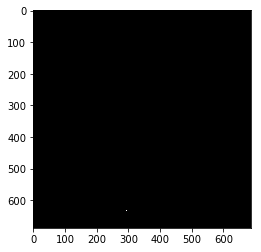

In [7]:
tile = 0
path=df.path.str[:-4][tile]

img_bands = [cv2.imread(os.path.join(aux.DATA_FOLDER,path,band),cv2.IMREAD_GRAYSCALE) for band in bands]

image = img_bands[11]-img_bands[9]

thresh = cv2.threshold(image, fire_threshold, 255, cv2.THRESH_BINARY)[1]

thresh = cv2.dilate(thresh, None, iterations=4)
thresh = cv2.erode(thresh, None, iterations=2)

numPixels = cv2.countNonZero(thresh)

print('Detection criterion: ',numPixels,' > ', image.shape[1]*fire_pixels_pct,'?')

plt.imshow(thresh,cmap='gray')

plt.show()

Hm, just barely passed the test... Let's see the result of numPixels for every image.

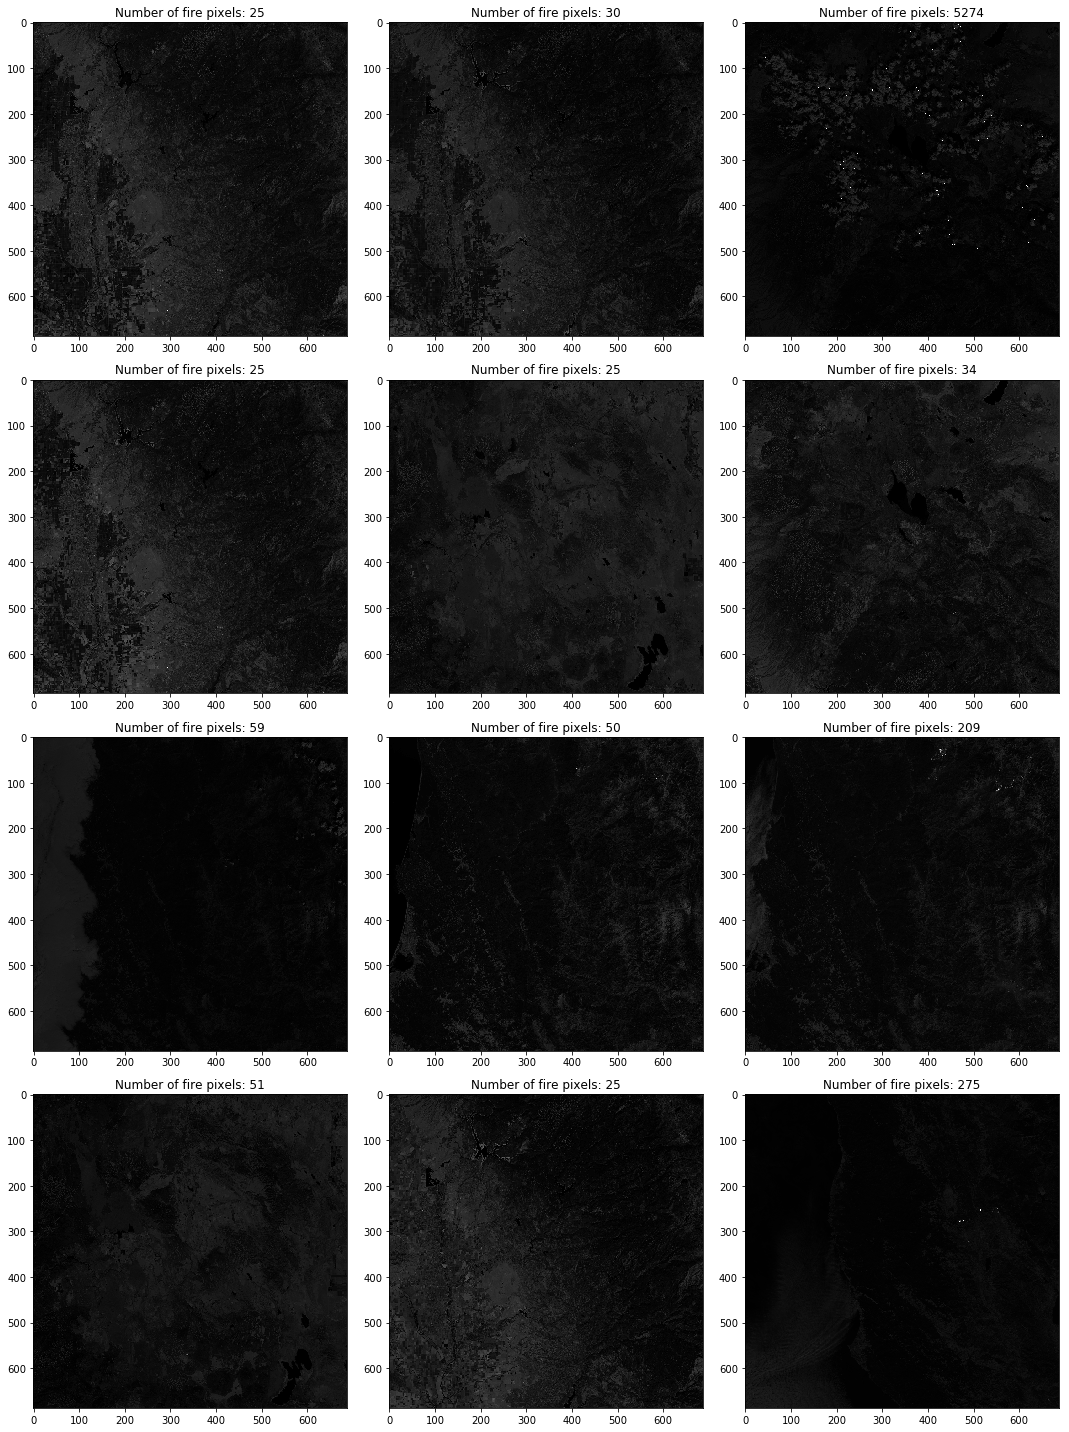

In [8]:
cols = 3
rows = math.ceil(len(df)/(cols))

f, axarr = plt.subplots(rows, cols, figsize=(15,20))

img_b12 = [cv2.imread(os.path.join(aux.DATA_FOLDER,path),cv2.IMREAD_GRAYSCALE) for path in df.path.str[:-4]+'/B12.jp2']
img_b11 = [cv2.imread(os.path.join(aux.DATA_FOLDER,path),cv2.IMREAD_GRAYSCALE) for path in df.path.str[:-4]+'/B11.jp2']
img_b10 = [cv2.imread(os.path.join(aux.DATA_FOLDER,path),cv2.IMREAD_GRAYSCALE) for path in df.path.str[:-4]+'/B10.jp2']

fire_threshold=90
n_pixels_threshold=0.01
numPixels = []

image = []

for i in range(len(df)):
    image.append(img_b12[i]-img_b10[i])
    
    thresh = cv2.threshold(image[i], fire_threshold, 255, cv2.THRESH_BINARY)[1]

    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = cv2.erode(thresh, None, iterations=2)
    
    numPixels.append(cv2.countNonZero(thresh))

times = df.timestamp.str[0:16]+' '+df.path.str[6:13]

c=0
for i in range(rows):
    for w in range(cols):
        if c == len(img):
            break
        axarr[i, w].imshow(image[c],cmap='gray')
        axarr[i, w].set_title('Number of fire pixels: '+str(numPixels[c]))
        c+=1
plt.tight_layout()

plt.show()

Those two large fires are around the 200 pixels and that third image is getting some ridiculous values... I'll look into the histograms for each B12 band now.

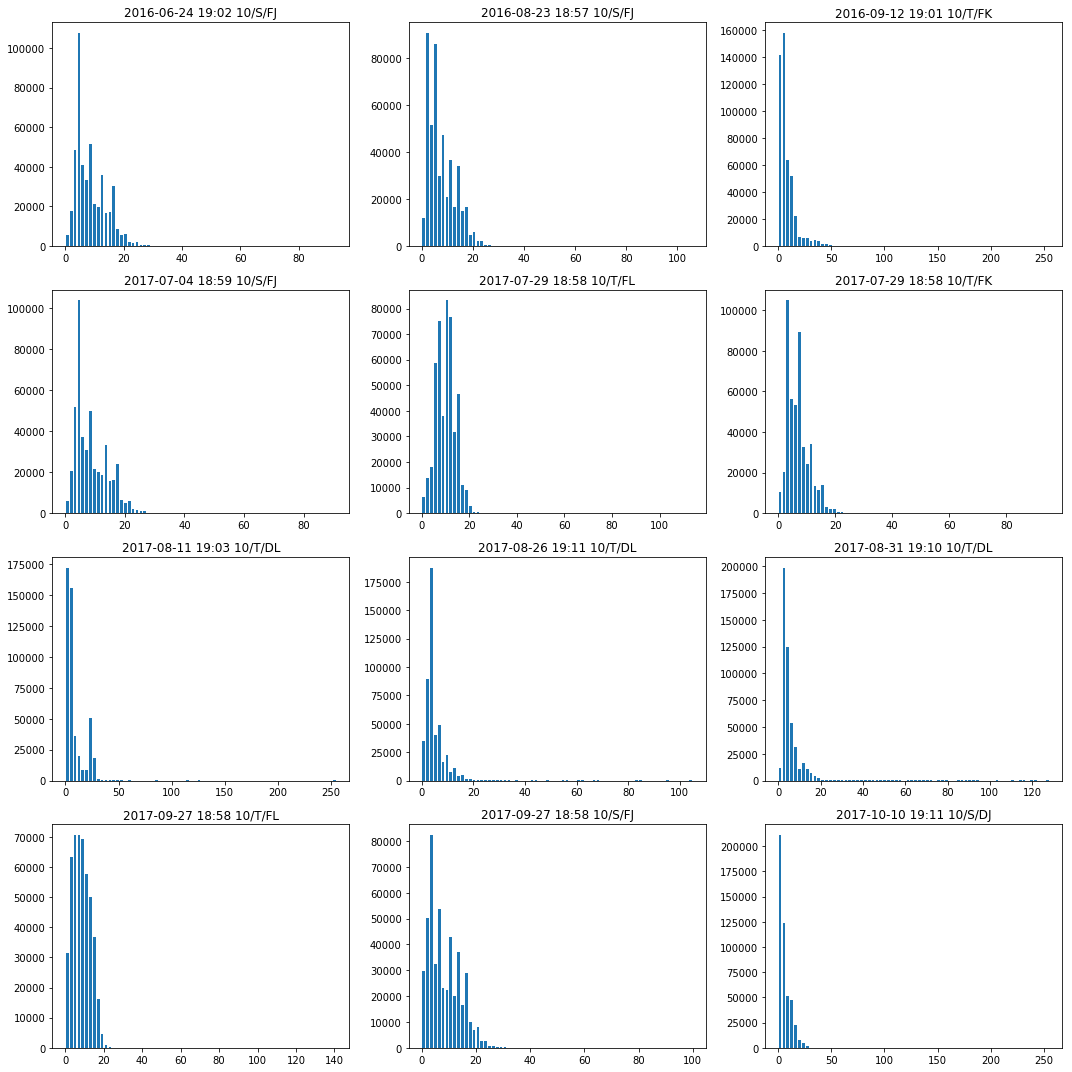

In [9]:
f, axarr = plt.subplots(rows, cols, figsize=(15,15))

times = df.timestamp.str[0:16]+' '+df.path.str[6:13]

c=0
for i in range(rows):
    for w in range(cols):
        if c == len(img_bands):
            break
        hist, bins = numpy.histogram(image[c], bins=70)
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        axarr[i, w].bar(center,hist,align='center', width=width)
        axarr[i, w].set_title(times[c])
        c+=1
        
plt.tight_layout()
plt.show()

Ok, clearly this criterion is not enough... Maybe we should also incorporate the smoke, by exploring some other bands.

Still, let's take a closer look at that supposed fire section detected in the first image using the EO Browser.

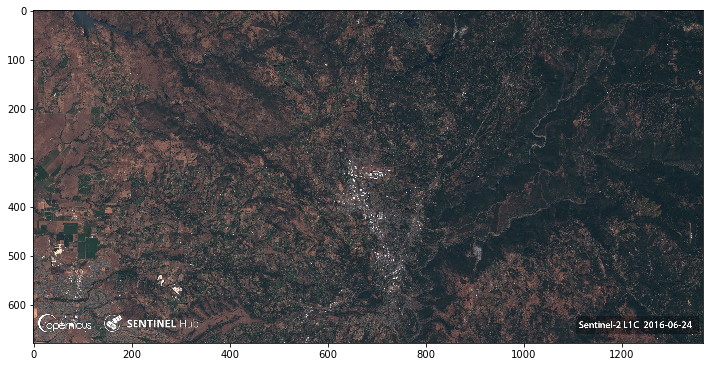

In [10]:
image = mpimg.imread('search_closer.jpg')
plt.figure(figsize=(12,24))
plt.imshow(image)
plt.show()

Oh! So I'm detecting a city... This B12 band is detecting cement roads and buildings the same as burnt regions...

Well, it seems there's really nothing better than to look at the data!